In [1]:
river_inputfilename="river_4326.geojson"
measures_inputfilename="measures_4326.geojson"
max_distance=2000 # in meters

## Loading data

In [2]:
import matplotlib.pyplot as plt

In [3]:
import fiona
from shapely.ops import split
from shapely.geometry import Point, LineString, shape
import json
with open(river_inputfilename) as f:
    features = json.load(f)["features"]
lines = []
for feat in features:
    s = shape(feat["geometry"])
    if s.geom_type == 'LineString':
        lines.append(s)
    elif s.geom_type == 'MultiLineString':
        for l in s.geoms:
            if l.geom_type != 'LineString':
                print('Erreur, cette primitive devrait être une ligne : '+str(l))
            lines.append(l)
    else:
        print('Erreur, ce type de primitives n\'est pas supporté : '+str(s.geom_type))
measures = [Point(point['geometry']['coordinates']) for point in fiona.open(measures_inputfilename)]
# Simpler example
#lines = [LineString(([0,0],[2,2],[2,3],[1,3])),LineString(([2,2],[3,1])),LineString(([2,3],[3,3]))]
#measures = [Point(([0,0])),Point(([2,2.3]))]
#max_distance=100000

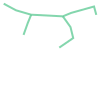

In [4]:
from shapely.geometry import Point, LineString, shape, GeometryCollection
GeometryCollection(lines)

Let plot the given river network and the measurement stations (red triangles)

Text(0.5, 1.0, 'Initial data')

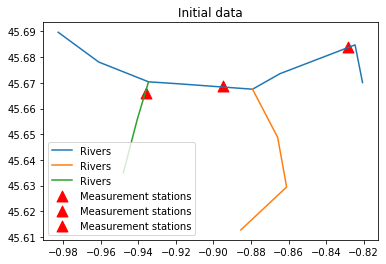

In [5]:
for line in lines:
    x,y = line.coords.xy
    plt.plot(x,y, label='Rivers')
for m in measures:
    x,y=m.xy
    plt.scatter(x,y,c='red',marker='^',s=120,label='Measurement stations')
plt.legend()
plt.title('Initial data')

## Find confluences

In [6]:
import networkx as nx

In [7]:
G = nx.Graph()
for line in lines:
   # convert the line segments to Graph edges
   for seg_start, seg_end in zip(line.coords,line.coords[1:]):
        G.add_edge(seg_start, seg_end)

In [8]:
from shapely.geometry import Point, LineString
for node in G.nodes:
    if G.degree(node) > 2:
        print(Point(node)) #the nodes
        for edge in G.edges(node):
            print(LineString(edge)) # the edges (>2)
confluences = [Point(node) for node in G.nodes if G.degree(node) > 2]

POINT (-0.93465404226 45.67039316284)
LINESTRING (-0.93465404226 45.67039316284, -0.96119539991 45.67808951538)
LINESTRING (-0.93465404226 45.67039316284, -0.91912734804 45.6696512898)
LINESTRING (-0.93465404226 45.67039316284, -0.94062624585 45.65583238563)
POINT (-0.87918260478 45.66751835004)
LINESTRING (-0.87918260478 45.66751835004, -0.91912734804 45.6696512898)
LINESTRING (-0.87918260478 45.66751835004, -0.86458485807 45.67354601355)
LINESTRING (-0.87918260478 45.66751835004, -0.86577961729 45.64878236148)


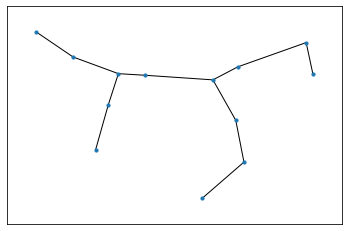

In [9]:
nx.draw_networkx(G,pos={n:n for n in G.nodes},with_labels=False, node_size=10)

## Snap measure points on river

In [10]:
dmin=lines[0].distance(measures[2])
idx_dmin=0
for i,l in enumerate(lines[1:]):
    d=l.distance(measures[2])
    if d<dmin:
        idx_dmin=i+1
        dmin=d

In [11]:
projMeasures=[]
for m in measures:
    # found the nearest line to the measure
    dmin=lines[0].distance(m)
    idx_dmin=0
    for i,l in enumerate(lines[1:]):
        d=l.distance(m)
        if d<dmin:
            idx_dmin=i+1
            dmin=d
    # projetting the point on the line
    projP = lines[idx_dmin].interpolate(lines[idx_dmin].project(m))
    projMeasures.append(projP)
    # inserting the projetted point in the line
    for i,(a,b) in enumerate(zip(lines[idx_dmin].coords,lines[idx_dmin].coords[1:])):
        if LineString([a,b]).distance(projP)<1e-4:
            newLine=LineString(lines[idx_dmin].coords[:i+1] + [projP] + lines[idx_dmin].coords[i+1:])
            break
    lines[idx_dmin] = newLine    

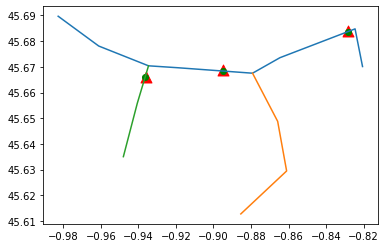

In [12]:
for line in lines:
    x,y = line.coords.xy
    plt.plot(x,y)
for m in measures:
    x,y=m.xy
    plt.scatter(x,y,c='red',marker='^',s=120)
for m in projMeasures:
    x,y=m.xy
    plt.scatter(x,y,c='green')

## Split at measures andconfluences

In [13]:
splitPts = confluences + projMeasures
waterways = lines[:]
newwaterways=[]
for waterway in waterways:
    ways=[waterway]
    for p in splitPts:
        nextways=[]
        for way in ways:
            if way.contains(p):
                splitted = list(split(way,p))
                nextways.extend(splitted)
            else:
                nextways.append(way)
        ways=nextways
    newwaterways.extend(ways)
len(newwaterways)

8

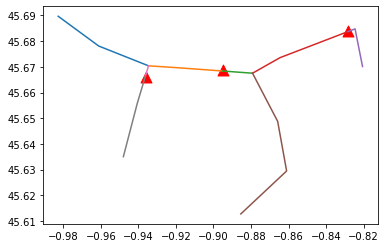

In [14]:
for line in newwaterways:
    x,y = line.coords.xy
    plt.plot(x,y)
for m in measures:
    x,y=m.xy
    plt.scatter(x,y,c='red',marker='^',s=120)

## Cut at a given distance

In [15]:
from math import radians, cos, sin, asin, sqrt, atan2,ceil
def haversine(coords):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    ((lon1, lat1), (lon2, lat2)) = coords
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a)) 
    return 6367000 * c


In [16]:
newMeasurePoints = []
for w in newwaterways:
    distW = 0
    for coords in zip(w.coords,w.coords[1:]):
        distW += haversine(coords)
    if distW > max_distance:
        # how many division we want
        nbDiv = ceil(distW / max_distance)
        # the target length of each division
        lenDiv = distW / nbDiv
        cumulDist = 0
        nbNewPts = 0
        for a,b in zip(w.coords,w.coords[1:]):
            dist = haversine((a,b))
            while cumulDist+dist > lenDiv:
                ratio = (lenDiv - cumulDist) / dist
                newX = a[0] + (b[0] - a[0])*ratio
                newY = a[1] + (b[1] - a[1])*ratio
                newMeasurePoints.append([newX,newY])
                nbNewPts += 1
                if nbNewPts == nbDiv-1:
                    break
                cumulDist = 0
                dist -= haversine((a,(newX,newY)))
                a=(newX,newY)
            if nbNewPts == nbDiv-1:
                break
            else:
                cumulDist += dist

In [17]:
newMeasurePoints

[[-0.9680139136048053, 45.681742526576706],
 [-0.951892577225091, 45.675391921536296],
 [-0.9149081162728034, 45.66942599439294],
 [-0.8629494048533699, 45.67400383078135],
 [-0.8455720690998073, 45.6788683195127],
 [-0.8688772625634824, 45.653112548794596],
 [-0.8630319487786069, 45.63768266310711],
 [-0.8689585155129361, 45.62403932699738],
 [-0.9424687885167868, 45.65067992543237]]

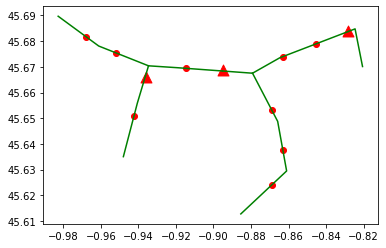

In [18]:
for line in newwaterways:
    x,y = line.coords.xy
    plt.plot(x,y,c='green')
for m in measures:
    x,y=m.xy
    plt.scatter(x,y,c='red',marker='^',s=120)
for p in newMeasurePoints:
    plt.scatter(p[0],p[1],c='red')
